In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy.stats as st 
import CLVAE

# Define Dataset and Hyperparameters

In [ ]:
config_options = {
    "mnist": {
        'dataset': 'mnist',
        "network": {
            "latent_dim": 2,
            "intermediate_dims": [[32,3,2],[64,3,2]]
        },
    },
    "fashion_mnist": {
        'dataset': 'fashion_mnist',
        "network": {
            "latent_dim": 3,
            "intermediate_dims": [[16,3,1],[32,3,2],[64,3,2]]
        },
    },
    "cifar10": {
        'dataset': 'cifar10',
        "network": {
            "latent_dim": 3,
            "intermediate_dims": [[64,3,2],[128,3,2],[256,3,2]]
        },
    }
}

In [118]:
config = config_options['mnist']

print("Loading Data")
x_train, y_train, x_test, y_test, x_anom, y_anom, config = CLVAE.load_data(config)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_anom.shape, y_anom.shape)

anomalous_digit = config['anomalous_digit']
dataset = config['dataset']
if config['network']['latent_dim'] == 3: dataset += "_dim3"

y_train[y_train >= anomalous_digit] = y_train[y_train >= anomalous_digit] + 1
y_test[y_test >= anomalous_digit] = y_test[y_test >= anomalous_digit] + 1
y_anom[:] = anomalous_digit


Loading Data
(54000, 28, 28, 1) (54000,)
(9000, 28, 28, 1) (9000,)
(7000, 28, 28, 1) (7000,)


## Transform data to latent space based on batch trained models

In [ ]:
result = {}
for model_type in ['clvae', 'vae']:

    # build model architecture
    if model_type == 'clvae':
        model, encoder, decoder = CLVAE.build_clvae(config)
    else:
        model, encoder, decoder = CLVAE.build_vae(config)

    # load weights
    path = "models/" + dataset + "/" + model_type
    f = sorted(os.listdir(path))[0]
    model.load_weights(path + "/" + f + "/model")
    encoder.load_weights(path + "/" + f + "/encoder")
    decoder.load_weights(path + "/" + f + "/decoder")

    # convert to latent space
    z_train_clvae = encoder.predict(x_train)
    z_test_clvae = encoder.predict(x_test)
    z_anom_clvae = encoder.predict(x_anom)

    # perform recreation of input
    x_rec_train_clvae = decoder.predict(z_train_clvae)
    x_rec_test_clvae = decoder.predict(z_test_clvae)
    x_rec_anom_clvae = decoder.predict(z_anom_clvae)

    result[model_type] = {
        'model': model,
        'encoder': encoder,
        'decoder': decoder,
        'x': [x_train, x_test, x_anom],
        'y': [y_train, y_test, y_anom],
        'z': [z_train_clvae, z_test_clvae, z_anom_clvae],
        'rec': [x_rec_train_clvae, x_rec_test_clvae, x_rec_anom_clvae],
    }

## Visualize latent space for 2d case

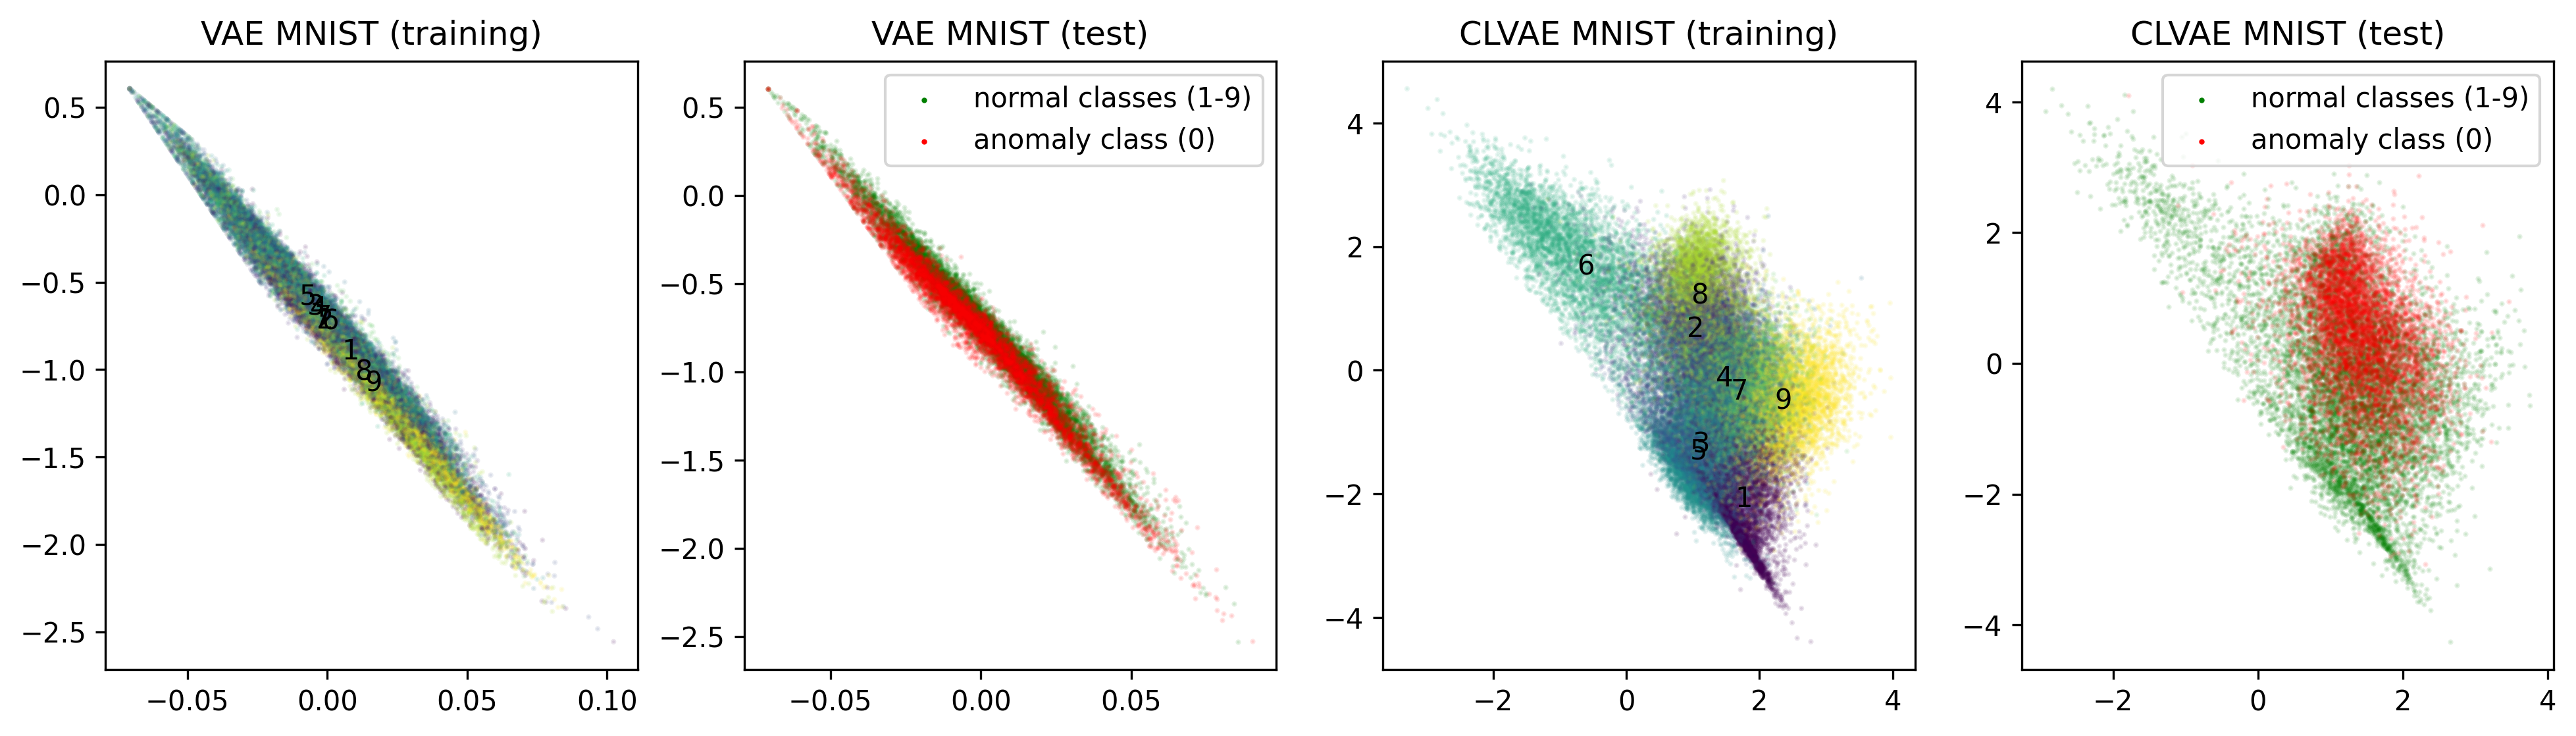

In [92]:
plt.figure(figsize=(16,4), dpi=300)
s = 1
alpha = 0.1

idx = 0
for typ in ['vae', 'clvae']:
    i = 0

    plt.subplot(1,4,idx*2 + 1)
    plt.title(typ.upper() + " MNIST (training)")
    plt.scatter(result[typ]['z'][i][:, 0], result[typ]['z'][i][:, 1], c=result[typ]['y'][i], alpha=alpha, s=s); 
    
    for cls in set(result[typ]['y'][i]):
        fltr = result[typ]['y'][i] == cls
        plt.text(np.mean(result[typ]['z'][i][fltr, 0]), np.mean(result[typ]['z'][i][fltr, 1]), str(cls), ha='center', va='center')
    
    i += 1
    
    plt.subplot(1,4,idx*2 + 2)
    plt.title(typ.upper() + " MNIST (test)")
    plt.scatter(result[typ]['z'][i][:, 0], result[typ]['z'][i][:, 1], c='green', alpha=alpha, s=s); i += 1
    plt.scatter(result[typ]['z'][i][:, 0], result[typ]['z'][i][:, 1], c='red', alpha=alpha, s=s); i += 1
    leg = plt.legend(["normal classes (1-9)", "anomaly class (0)"])
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    idx += 1

#plt.savefig("test.svg")

## Visualize latent space for 3d case

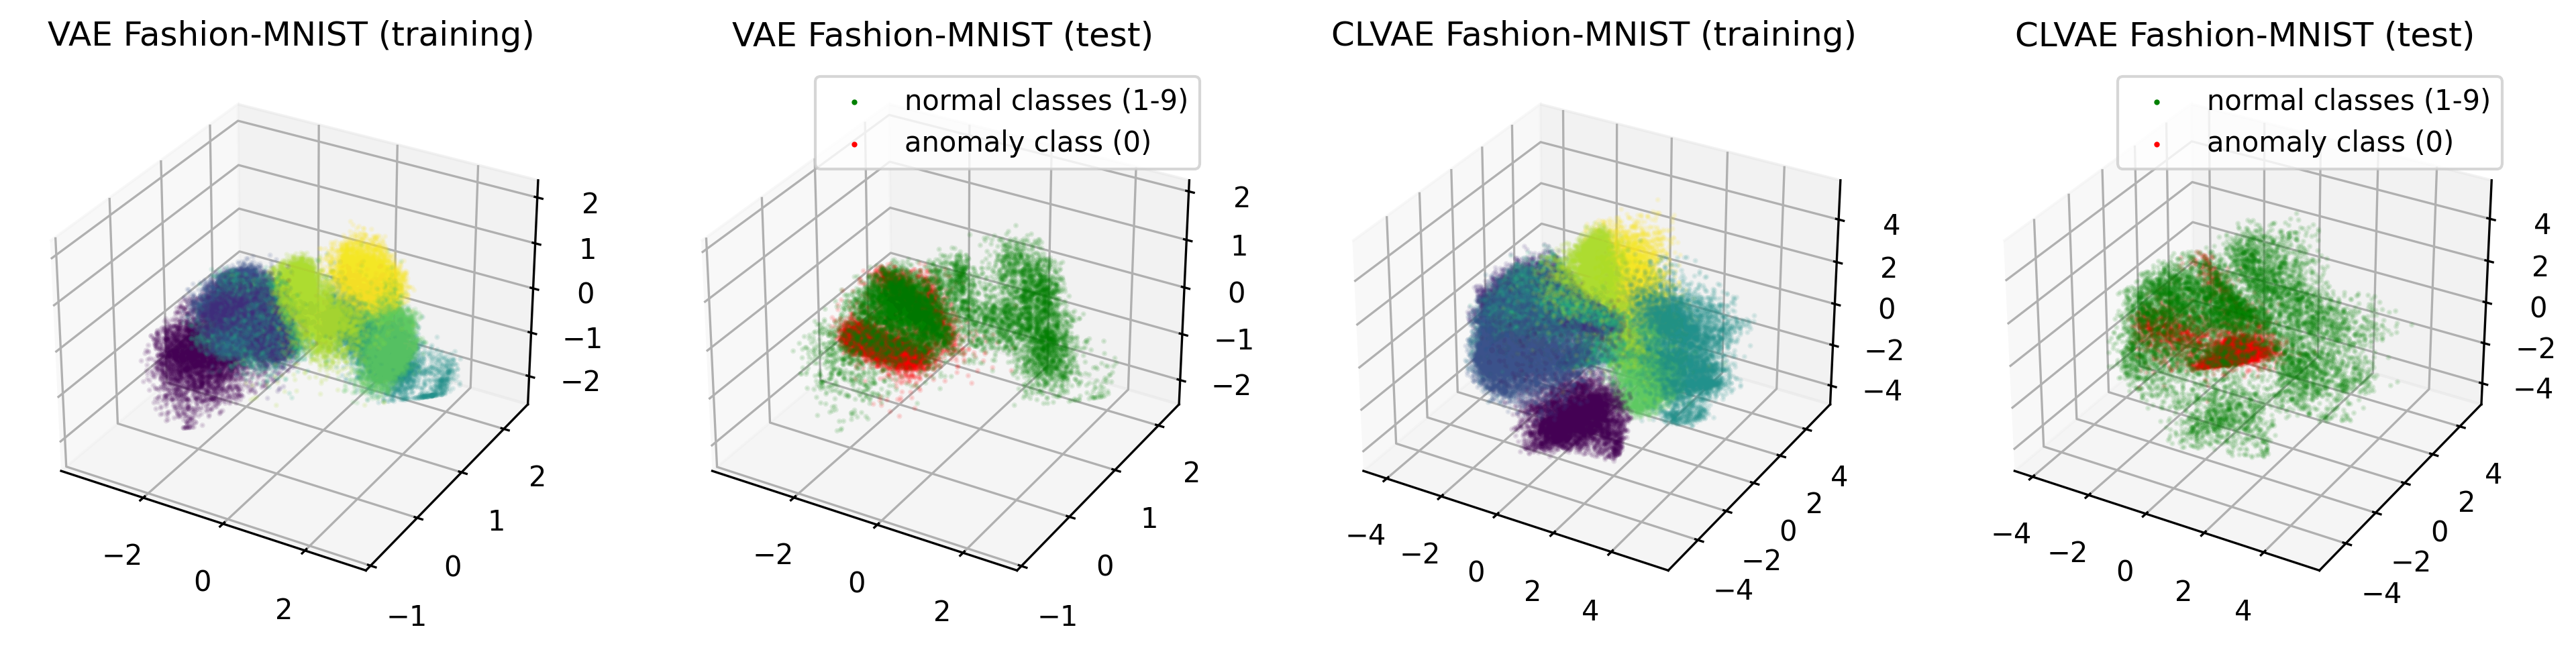

In [120]:



plt.figure(figsize=(16,4), dpi=300)
s = 1
alpha = 0.1

idx = 0
name = ['VAE', 'CL-VAE']
for typ in ['vae', 'clvae']:
    i = 0

    ax = plt.subplot(1, 4, idx*2 + 1, projection='3d')
    plt.title(typ.upper() + " Fashion-MNIST (training)")
    ax.scatter(result[typ]['z'][i][:, 0], result[typ]['z'][i][:, 1], result[typ]['z'][i][:, 2], c=result[typ]['y'][i], alpha=alpha, s=s); 
    
    #for cls in set(result[typ]['y'][i]):
        #fltr = result[typ]['y'][i] == cls
        #plt.text(np.mean(result[typ]['z'][i][fltr, 0]), np.mean(result[typ]['z'][i][fltr, 1]), str(cls), ha='center', va='center')
    
    i += 1
    
    ax = plt.subplot(1, 4, idx*2 + 2, projection='3d')
    plt.title(typ.upper() + " Fashion-MNIST (test)")
    ax.scatter(result[typ]['z'][i][:, 0], result[typ]['z'][i][:, 1], result[typ]['z'][i][:, 2], c='green', alpha=alpha, s=s); i += 1
    ax.scatter(result[typ]['z'][i][:, 0], result[typ]['z'][i][:, 1], result[typ]['z'][i][:, 2], c='red', alpha=alpha, s=s); i += 1
    leg = ax.legend(["normal classes (1-9)", "anomaly class (0)"])
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    idx += 1

#plt.savefig("test.svg")

# Compare AUC when Ensembling

In [33]:


CIS = {}

for dataset_name in config_options:
    config_edit = config_options[dataset_name]

    print("Loading Data")
    x_train, y_train, x_test, y_test, x_anom, y_anom, config = CLVAE.load_data(config_edit)
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    print(x_anom.shape, y_anom.shape)

    anomalous_digit = config['anomalous_digit']
    dataset = config['dataset']
    if config['network']['latent_dim'] == 3: dataset += "_dim3"


    clvae_ld = np.load("confidences/" + dataset + "/clvae_ld.npy")
    clvae_mse = np.load("confidences/" + dataset + "/clvae_mse.npy")
    vae_mse = np.load("confidences/" + dataset + "/vae_mse.npy")
    cnn_score = np.load("confidences/" + dataset + "/cnn_score.npy")
    pca_score = np.load("confidences/" + dataset + "/pca_score.npy")

    normal_digits = list(range(0, anomalous_digit)) + list(range(anomalous_digit+1, 10))


    def get_auc(mse, mn, mx):
        N = int(len(mse)/2)
        TPR = []
        FPR = []
        for t in range(100):
            thresh = mn + t/100*(mx - mn)
            true_normal = np.sum(mse[:N] < thresh)
            false_outliers = np.sum(mse[:N] >= thresh)
            false_normal = np.sum(mse[N:] < thresh)
            true_outliers = np.sum(mse[N:] >= thresh)
            TPR.append(true_outliers/(true_outliers + false_normal))
            FPR.append(false_outliers/(false_outliers + true_normal))
        AUC = sklearn.metrics.auc(FPR, TPR)
        return AUC


    CIs_clvae_ld = np.zeros([10, 3])
    CIs_clvae_mse = np.zeros([10, 3])
    CIs_vae_mse = np.zeros([10, 3])
    CIs_cnn_score = np.zeros([10, 3])

    for NE in range(1, 11):
        print("Ensamble", NE)
        aucs = []
        for i in range(clvae_ld.shape[2]):
            mse = clvae_ld[:, :, i]
            for j in range(NE-1): mse += clvae_ld[:, :, (i + (j+1)) % clvae_ld.shape[2]]
            mse /= NE
            conf = np.max(mse[:, normal_digits], axis=1)
            AUC = 1-get_auc(conf, np.min(mse), np.max(mse))
            aucs.append(AUC)
        print(aucs)
        print(np.mean(aucs), np.std(aucs))
        ci = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs)) 
        CIs_clvae_ld[NE-1, :] = [ci[0], np.mean(aucs), ci[1]]


        aucs = []
        for i in range(clvae_mse.shape[1]):
            mse = clvae_mse[:, i]
            for j in range(NE-1): mse += clvae_mse[:, (i + (j+1)) % clvae_mse.shape[1]]
            mse /= NE
            AUC = get_auc(mse, np.min(mse), np.max(mse))
            aucs.append(AUC)
        print(aucs)
        print(np.mean(aucs), np.std(aucs))
        ci = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs)) 
        CIs_clvae_mse[NE-1, :] = [ci[0], np.mean(aucs), ci[1]]

        # VAE
        aucs = []
        for i in range(vae_mse.shape[1]):
            mse = vae_mse[:, i]
            for j in range(NE-1): mse += vae_mse[:, (i + (j+1)) % vae_mse.shape[1]]
            mse /= NE
            AUC = get_auc(mse, np.min(mse), np.max(mse))
            aucs.append(AUC)
        print(aucs)
        print(np.mean(aucs), np.std(aucs))
        ci = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs)) 
        CIs_vae_mse[NE-1, :] = [ci[0], np.mean(aucs), ci[1]]

        #CNN
        aucs = []
        for i in range(cnn_score.shape[1]):
            mse = cnn_score[:, i]
            for j in range(NE-1): mse += cnn_score[:, (i + (j+1)) % cnn_score.shape[1]]
            mse /= NE
            AUC = get_auc(mse, np.min(mse), np.max(mse))
            aucs.append(AUC)
        print(aucs)
        print(np.mean(aucs), np.std(aucs))
        ci = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs)) 
        CIs_cnn_score[NE-1, :] = [ci[0], np.mean(aucs), ci[1]]


    # PCA
    score = pca_score
    pca_auc = get_auc(score, np.min(score), np.max(score))

    CIS[config['dataset']] = {
        'clvae_ld': CIs_clvae_ld,
        'clvae_mse': CIs_clvae_mse,
        'vae_mse': CIs_vae_mse,
        'cnn_score': CIs_cnn_score,
        'pca': pca_auc
    }





Loading Data
(54077, 28, 28, 1) (54077,)
(9020, 28, 28, 1) (9020,)
(6903, 28, 28, 1) (6903,)
Ensamble 1
[0.8877589537803594, 0.9515703407636907, 0.8885725603622759, 0.9034170846868348, 0.9548536224815514, 0.917688603919351, 0.9310138657180106, 0.8911513403517617, 0.9107620301426973, 0.8846438202908123]
0.9121432222497343 0.0248809695103778
[0.9465175206046899, 0.9377106456600266, 0.9424402749559829, 0.9509316712964353, 0.9469871289640145, 0.9467943539717787, 0.936429298449496, 0.9472742978072275, 0.9408738469832025, 0.9520505259351303]
0.9448009564627984 0.00499310611555232
[0.9360785113405565, 0.9424110733011064, 0.9425319616467165, 0.9453642703408833, 0.9394379503027916, 0.9519434566982059, 0.9492440506848392, 0.9620981931510149, 0.9563823495754344, 0.9441024608527315]
0.9469594277894279 0.007576261982698086
[0.8955074130126982, 0.8430517657935361, 0.8554856163854461, 0.8623070935845779, 0.8764737051112172, 0.878379818737364, 0.914546703120573, 0.8099270055162482, 0.8511346642446608,

In [75]:
CIS['mnist']['vae_mse'][-1]

array([0.95670121, 0.9567021 , 0.956703  ])

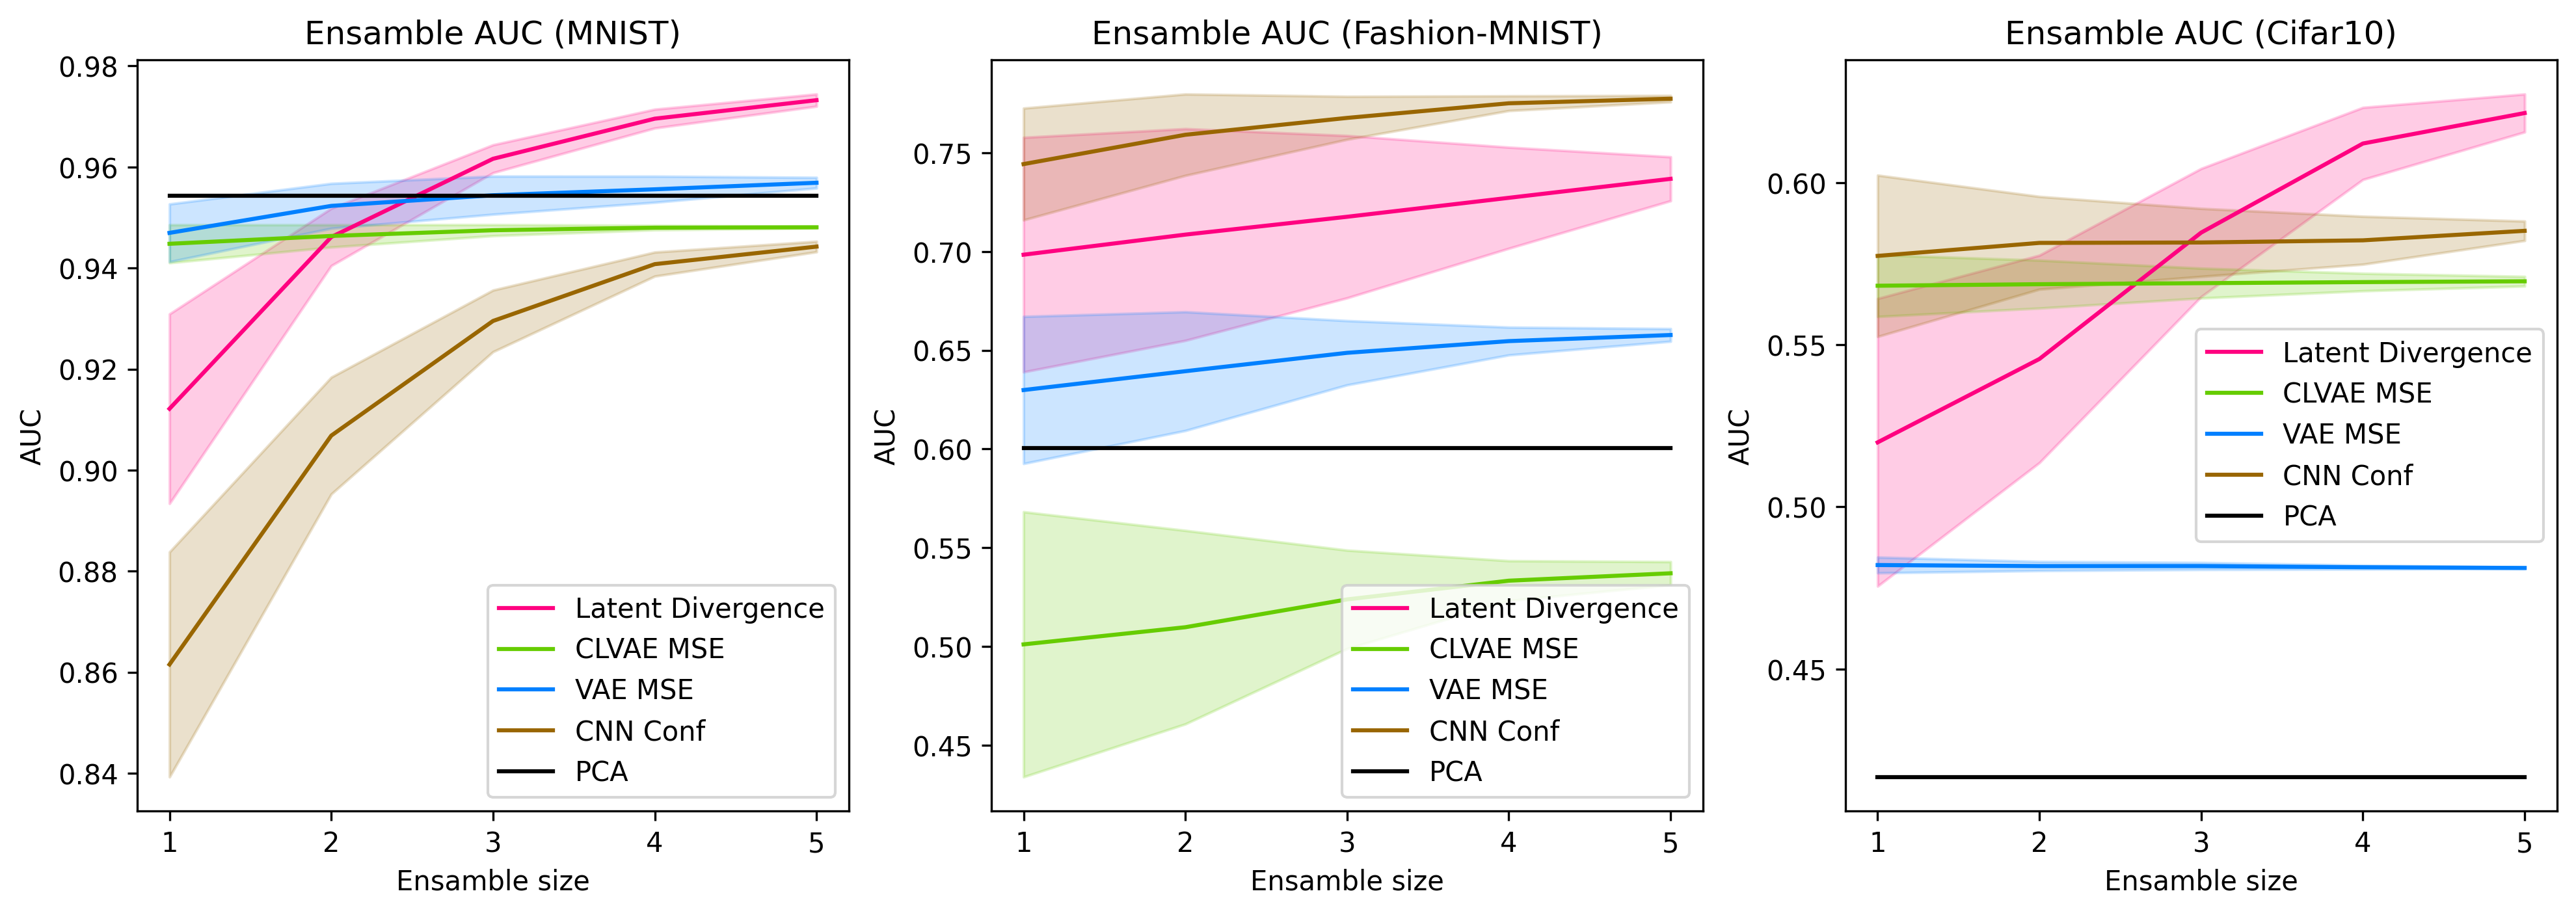

In [34]:
plt.figure(figsize=(16,5), dpi=300)
names = ["MNIST", "Fashion-MNIST", "Cifar10"]

K = 5
i = 1
for c in CIS:
    ax = plt.subplot(1,3,i)
    colors = [[1,0,0.5], [0.4,0.8,0.0], [0,0.5,1], [0.6,0.4,0], [0,0,0]]
    plt.plot(range(1,K+1), CIS[c]['clvae_ld'][:K, 1], color=colors[0])
    plt.plot(range(1,K+1), CIS[c]['clvae_mse'][:K, 1], color=colors[1])
    plt.plot(range(1,K+1), CIS[c]['vae_mse'][:K, 1], color=colors[2])
    plt.plot(range(1,K+1), CIS[c]['cnn_score'][:K, 1], color=colors[3])
    plt.plot([1,K], [CIS[c]['pca'], CIS[c]['pca']], color=colors[4])
    ax.fill_between(range(1,K+1), CIS[c]['clvae_ld'][:K, 0], CIS[c]['clvae_ld'][:K, 2], color=colors[0], alpha=.2)
    ax.fill_between(range(1,K+1), CIS[c]['clvae_mse'][:K, 0], CIS[c]['clvae_mse'][:K, 2], color=colors[1], alpha=.2)
    ax.fill_between(range(1,K+1), CIS[c]['vae_mse'][:K, 0], CIS[c]['vae_mse'][:K, 2], color=colors[2], alpha=.2)
    ax.fill_between(range(1,K+1), CIS[c]['cnn_score'][:K, 0], CIS[c]['cnn_score'][:K, 2], color=colors[3], alpha=.2)
    plt.legend(["Latent Divergence", "CLVAE MSE", "VAE MSE", "CNN Conf", "PCA"])
    plt.title("Ensamble AUC (" + names[i-1] + ")")
    plt.xlabel("Ensamble size")
    plt.ylabel("AUC")
    i += 1

# Anomalies

In [36]:

configs = [
    {
        'anomalous_digit': 0, 
        'dataset': 'mnist',
        "network": {
            "latent_dim": 2,
            "img_dim": 28,
            "color_dim": 1,
            "intermediate_dims": [[32,3,2],[64,3,2]]
        },
    },{
        'anomalous_digit': 0, 
        'dataset': 'fashion_mnist',
        "network": {
            "latent_dim": 3,
            "img_dim": 28,
            "color_dim": 1,
            "intermediate_dims": [[16,3,1],[32,3,2],[64,3,2]]
        },
    },{
        'anomalous_digit': 0, 
        'dataset': 'cifar10',
        "network": {
            "latent_dim": 3,
            "img_dim": 32,
            "color_dim": 3,
            "intermediate_dims": [[64,3,2],[128,3,2],[256,3,2]]
        },
    }
]



all_confs = []
all_data = []
for i in range(3):
    config_edit = configs[i]
    print("Loading Data")
    x_train, y_train, x_test, y_test, x_anom, y_anom, config = CLVAE.load_data(config_edit)
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    print(x_anom.shape, y_anom.shape)

    anomalous_digit = config['anomalous_digit']
    dataset = config['dataset']
    if config['network']['latent_dim'] == 3: dataset += "_dim3"

    y_train[y_train >= anomalous_digit] = y_train[y_train >= anomalous_digit] + 1
    y_test[y_test >= anomalous_digit] = y_test[y_test >= anomalous_digit] + 1
    y_anom[:] = anomalous_digit

    clvae_ld = np.load("confidences/" + dataset + "/clvae_ld.npy")
    clvae_mse = np.load("confidences/" + dataset + "/clvae_mse.npy")
    vae_mse = np.load("confidences/" + dataset + "/vae_mse.npy")
    cnn_score = np.load("confidences/" + dataset + "/cnn_score.npy")
    pca_score = np.load("confidences/" + dataset + "/pca_score.npy")

    normal_digits = list(range(0, anomalous_digit)) + list(range(anomalous_digit+1, 10))

    confs = []

    mdl = 0
    conf = list(np.max(clvae_ld[:, normal_digits, mdl], axis=1))
    conf = [(c, i) for i,c in enumerate(conf)]
    normal_conf = sorted(conf[:int(len(conf)/2)])
    anom_conf = sorted(conf[int(len(conf)/2):], reverse=True)
    confs.append((normal_conf, anom_conf))

    conf = list(clvae_mse[:, mdl])
    conf = [(c, i) for i,c in enumerate(conf)]
    normal_conf = sorted(conf[:int(len(conf)/2)])
    anom_conf = sorted(conf[int(len(conf)/2):], reverse=True)
    confs.append((normal_conf, anom_conf))

    conf = list(vae_mse[:, mdl])
    conf = [(c, i) for i,c in enumerate(conf)]
    normal_conf = sorted(conf[:int(len(conf)/2)])
    anom_conf = sorted(conf[int(len(conf)/2):], reverse=True)
    confs.append((normal_conf, anom_conf))
    
    conf = list(cnn_score[:, mdl])
    conf = [(c, i) for i,c in enumerate(conf)]
    normal_conf = sorted(conf[:int(len(conf)/2)])
    anom_conf = sorted(conf[int(len(conf)/2):], reverse=True)
    confs.append((normal_conf, anom_conf))

    conf = list(pca_score)
    conf = [(c, i) for i,c in enumerate(conf)]
    normal_conf = sorted(conf[:int(len(conf)/2)])
    anom_conf = sorted(conf[int(len(conf)/2):], reverse=True)
    confs.append((normal_conf, anom_conf))
    
    all_confs.append(confs)
    all_data.append({'y_test':y_test, 'y_anom':y_anom, 'x_test': x_test, 'x_anom': x_anom})


Loading Data
(54077, 28, 28, 1) (54077,)
(9020, 28, 28, 1) (9020,)
(6903, 28, 28, 1) (6903,)
Loading Data
(54000, 28, 28, 1) (54000,)
(9000, 28, 28, 1) (9000,)
(7000, 28, 28, 1) (7000,)
Loading Data
(45000, 32, 32, 3) (45000,)
(9000, 32, 32, 3) (9000,)
(6000, 32, 32, 3) (6000,)


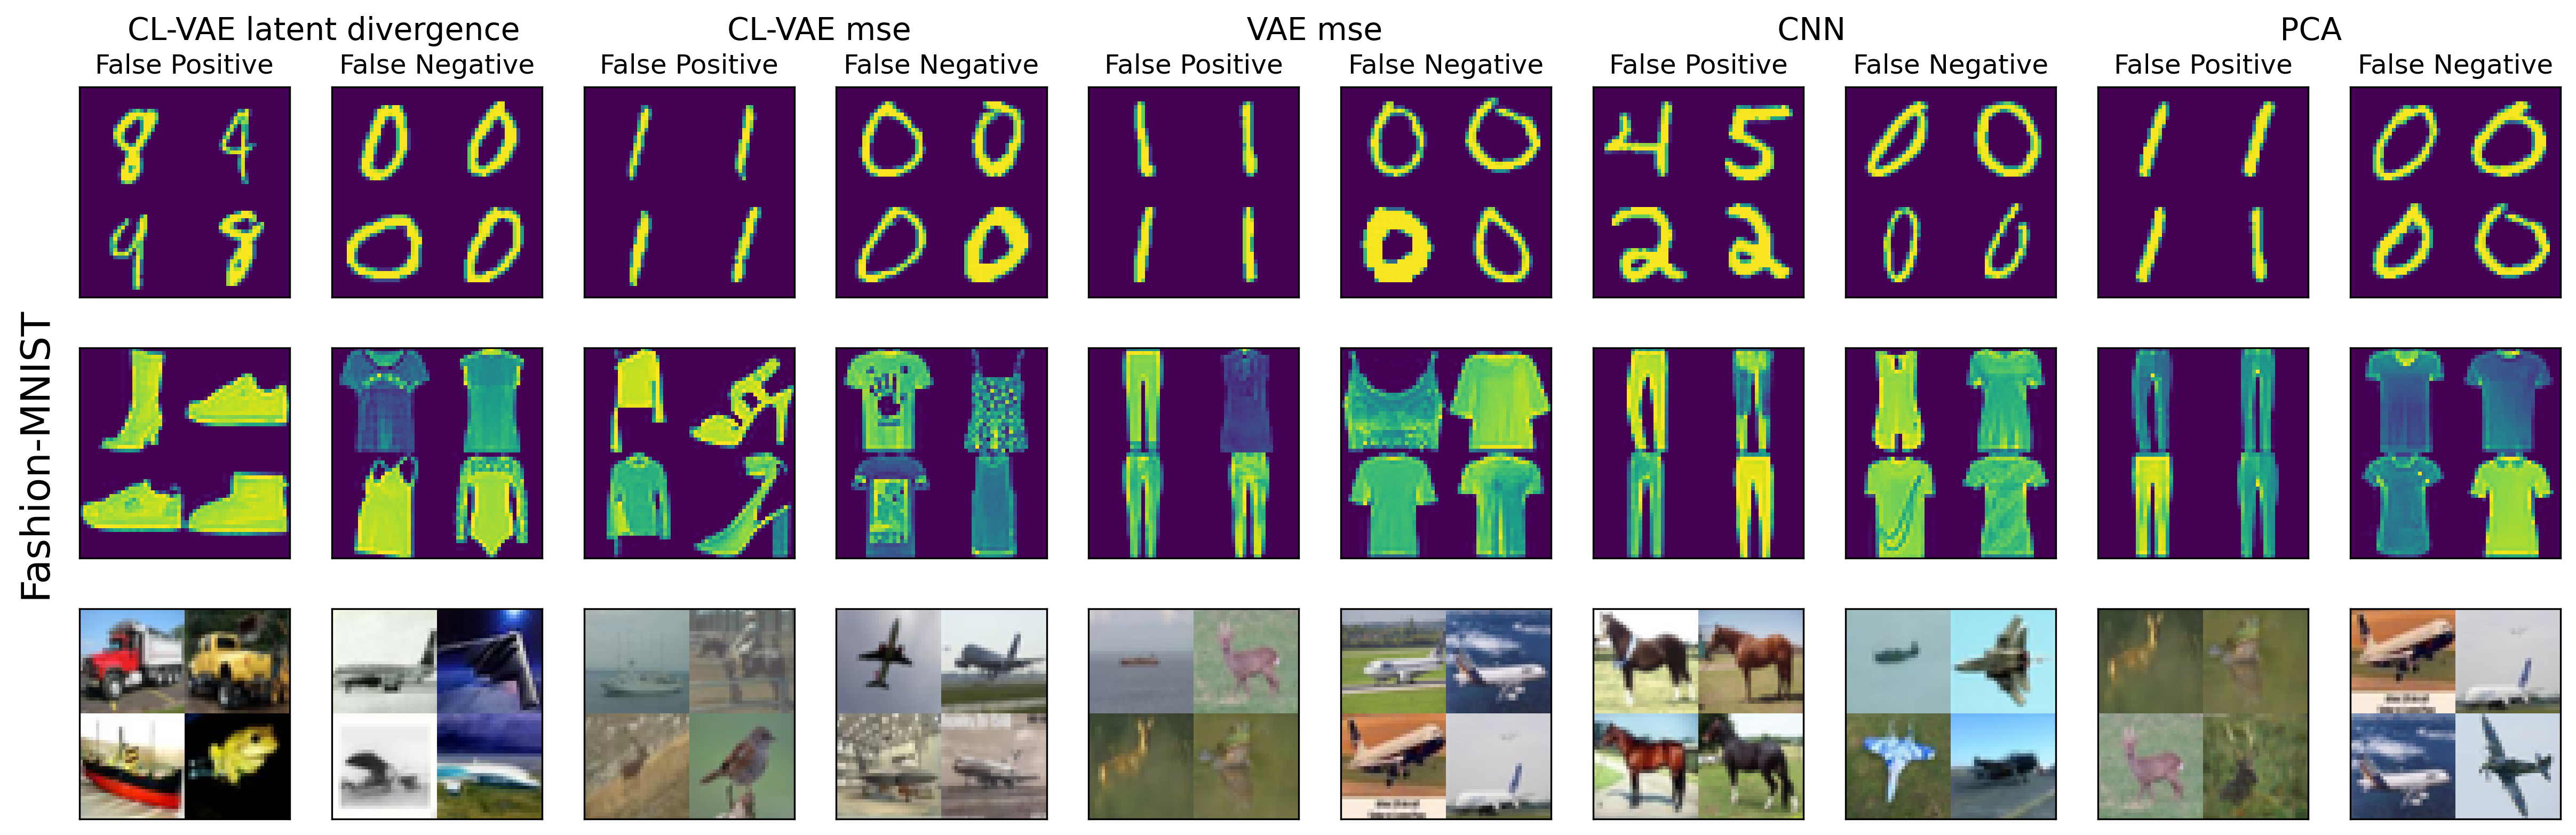

In [81]:






r = 3
fig = plt.figure(figsize=(10*2,r*2), dpi=300)
fig.suptitle('CL-VAE latent divergence                     CL-VAE mse                                  VAE mse                                        CNN                                            PCA', size=14, x=0.140, y=0.95, ha='left')
axs = fig.subplots(r, 10)
for j in range(5):
    for i in range(r):
        r2 = int(i / 1)
        confs = all_confs[r2]
        data = all_data[r2]
        c = 0
        ax = axs[i, 2*j + c]
        img = np.vstack((
            np.hstack((
                data['x_test'][confs[j][0][0][1], :, :, :], 
                data['x_test'][confs[j][0][1][1], :, :, :]
            )),
            np.hstack((
                data['x_test'][confs[j][0][2][1], :, :, :], 
                data['x_test'][confs[j][0][3][1], :, :, :]
            ))
        ))
        ax.imshow(img)
        ax.tick_params(left=False, bottom=False) 
        if i == 0: ax.set_title("False Positive", size=12)
        if j == 0 and i % 3 == 1: ax.set_ylabel(["MNIST", "Fashion-MNIST", "Cifar10"][r2], size=18)
        #ax.set_xlabel(data['y_test'][confs[j][0][2*i + 0][1]])
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        c += 1
        ax = axs[i, 2*j + c]
        if i == 0: ax.set_title("False Negative", size=12)
        img = np.vstack((
            np.hstack((
                data['x_anom'][confs[j][0][0][1], :, :, :], 
                data['x_anom'][confs[j][0][1][1], :, :, :]
            )),
            np.hstack((
                data['x_anom'][confs[j][0][2][1], :, :, :], 
                data['x_anom'][confs[j][0][3][1], :, :, :]
            ))
        ))
        ax.imshow(img)
        ax.tick_params(left=False, bottom=False) 
        ax.set_yticklabels([])
        ax.set_xticklabels([])